2023-11-21 19:16:14.117985: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 19:16:14.154955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 19:16:14.699553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Class=40, n=9196 (32.682%)
Class=19, n=1154 (4.101%)
Class=17, n=3392 (12.055%)
Class=10, n=219 (0.778%)
Class=27, n=254 (0.903%)
Class=45, n=1371 (4.872%)
Class=41, n=821 (2.918%)
Class=39, n=377 (1.340%)
Class=20, n=677 (2.406%)
Class=46, n=1586 (5.637%)
Class=13, n=1143 (4.062%)
Class=3, n=135 (0.480%)
Class=24, n=27 (0.096%)
Class=12, n=2425 (8.618%)
Class=22, n=1717 (6.102%)
Class=9, n=53 (0.188%)
Class=43, n=118 (0.419%)
Class=32, n=1371 (4.872%)
Class=25, n=44 (0.156%)
Class=6, n=247 (0.878%)
Class=44, n=119 (0.423%)
Class=2, n=225 (0.800%)
Class=15, n=370 (1.315%)
Class=16, n=146 (0.519%)
Class=35, n=47 (0.167%)
Class=1, n=22 (0.078%)
Class=30, n=22 (0.078%)
Class=21, n=69 (0.245%)
Class=11, n=134 (0.476%)
Class=5, n=29 (0.103%)
Class=0, n=15 (0.053%)
Class=28, n=4 (0.014%)
Class=18, n=59 (0.210%)
Class=7, n=262 (0.931%)
Class=4, n=51 (0.181%)
Class=29, n=10 (0.036%)
Class=8, n=10 (0.036%)
Class=42, n=175 (0.622%)
Class=38, n=15 (0.053%)
Class=14, n=2 (0.007%)
Class=31, n=7 (0.

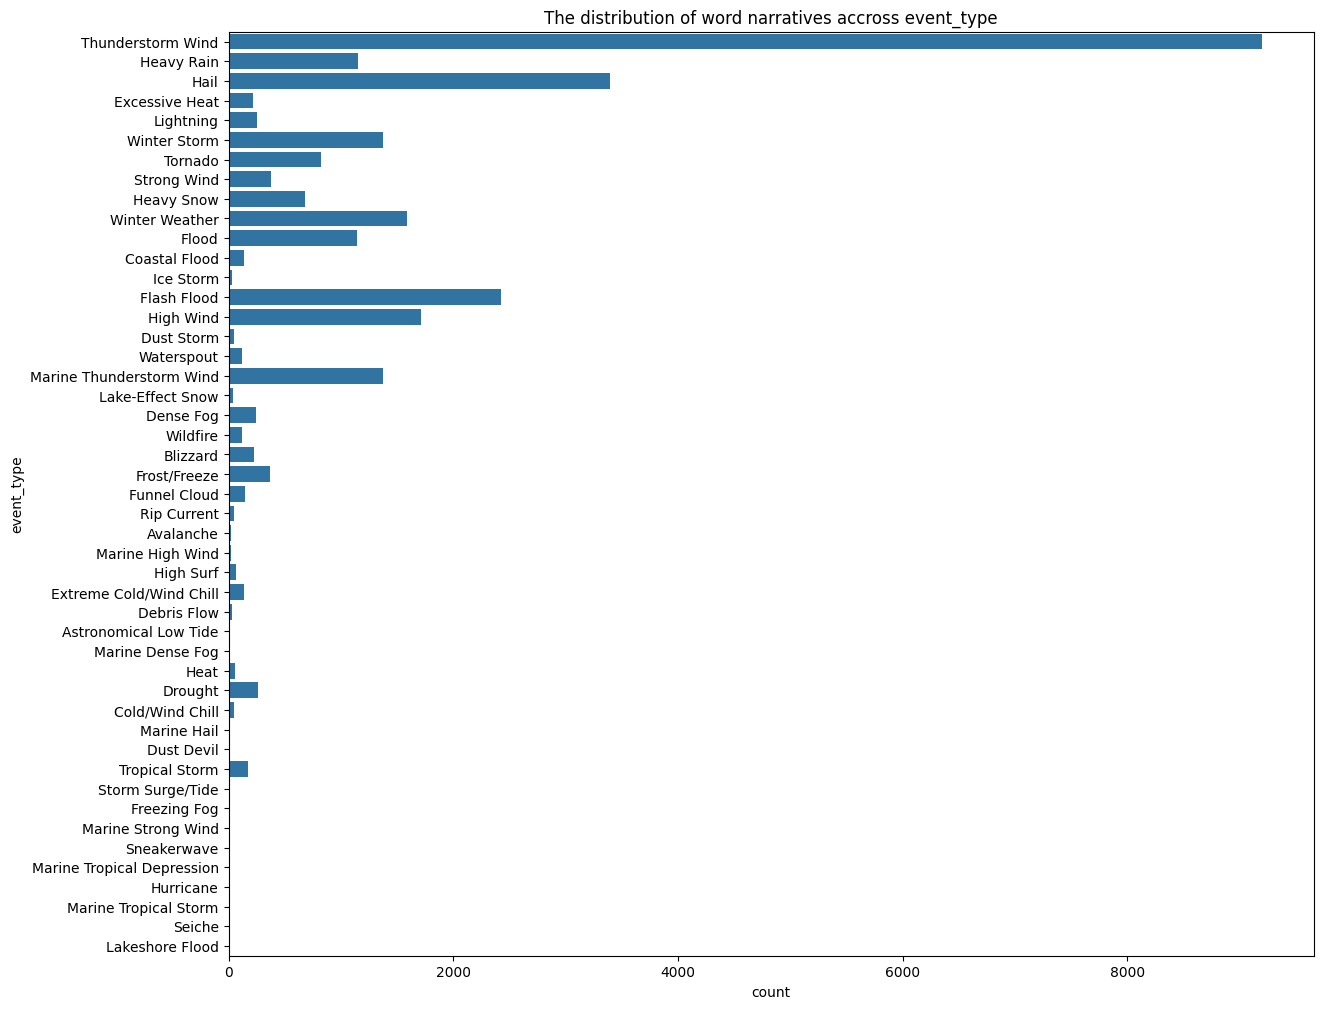

In [1]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Embedding
from imblearn.over_sampling import SMOTE

#!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip

# Load the data from the csv file
df = pd.read_csv('question6a.csv')
#df2 = pd.read_csv('question6b.csv', header=None)
# Extract relevant columns
df = df[['event_narrative', 'event_type']]

# Drop rows with missing values(rows)
df = df.dropna()
plt.figure(figsize=(14,12))
sns.countplot(df.event_type)
plt.title('The distribution of word narratives accross event_type')

from sklearn.preprocessing import LabelEncoder

# Extract the target variable
y = df['event_type']
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)

# Add the encoded labels to the DataFrame
df['encoded_labels'] = encoded_labels
from collections import Counter
counter = Counter(df['encoded_labels'])
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

from sklearn.model_selection import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(df['event_narrative'], df['encoded_labels'], test_size=0.2, random_state=434)

In [2]:
# Find the class with the maximum number of samples
max_samples = max(counter.values())/16

# Calculate the number of samples to augment for each class
samples_to_augment = {label: max_samples - count for label, count in counter.items()}

# Print the results
for label, count in samples_to_augment.items():
    print(f"Class={label}, Samples to Augment={count}")

Class=40, Samples to Augment=-8621.25
Class=19, Samples to Augment=-579.25
Class=17, Samples to Augment=-2817.25
Class=10, Samples to Augment=355.75
Class=27, Samples to Augment=320.75
Class=45, Samples to Augment=-796.25
Class=41, Samples to Augment=-246.25
Class=39, Samples to Augment=197.75
Class=20, Samples to Augment=-102.25
Class=46, Samples to Augment=-1011.25
Class=13, Samples to Augment=-568.25
Class=3, Samples to Augment=439.75
Class=24, Samples to Augment=547.75
Class=12, Samples to Augment=-1850.25
Class=22, Samples to Augment=-1142.25
Class=9, Samples to Augment=521.75
Class=43, Samples to Augment=456.75
Class=32, Samples to Augment=-796.25
Class=25, Samples to Augment=530.75
Class=6, Samples to Augment=327.75
Class=44, Samples to Augment=455.75
Class=2, Samples to Augment=349.75
Class=15, Samples to Augment=204.75
Class=16, Samples to Augment=428.75
Class=35, Samples to Augment=527.75
Class=1, Samples to Augment=552.75
Class=30, Samples to Augment=552.75
Class=21, Samples

In [3]:
import os
import sklearn.datasets
import re

import nlpaug.augmenter.word as naw
import nlpaug.model.word_stats as nmw

def _tokenizer(text, token_pattern=r"(?u)\b\w\w+\b"):
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(text)

# Load sample data
train_data = df['event_narrative']
train_y = encoded_labels
# Tokenize input
train_x_tokens = [_tokenizer(x) for x in train_data]

# Train TF-IDF model
tfidf_model = nmw.TfIdf()
tfidf_model.train(train_x_tokens)
tfidf_model.save('.')

# Load TF-IDF augmenter
aug = naw.TfIdfAug(model_path='.', tokenizer=_tokenizer)

In [4]:
train_data[1]

'One to two feet of deep standing water developed on a street on the Winthrop University campus after more than an inch of rain fell in less than an hour. One vehicle was stalled in the water.'

In [5]:
texts = [
    'Large tree down between Plantersville and Nettleton',
    'One to two feet of deep standing water developed on a street on the Winthrop University campus after more than an inch of rain fell in less than an hour. One vehicle was stalled in the water'
]

for text in texts:
    augmented_text = aug.augment(text)
    
    print('-'*20)
    print('Original Input:{}'.format(text))
    print('Agumented Output:{}'.format(augmented_text))

--------------------
Original Input:Large tree down between Plantersville and Nettleton
Agumented Output:['Tributaries tree Wantage between chaotic and Nettleton']
--------------------
Original Input:One to two feet of deep standing water developed on a street on the Winthrop University campus after more than an inch of rain fell in less than an hour. One vehicle was stalled in the water
Agumented Output:['One to two feet of deep standing water developed on 2273 Manzana the Winthrop Eagles campus 1345 more than Schodack inch of JM While in snowboard Lorain an hour One vehicle was stalled in the Whitleys']


In [6]:
import os
import re
import nlpaug.augmenter.word as naw
import nlpaug.model.word_stats as nmw

def _tokenizer(text, token_pattern=r"(?u)\b\w\w+\b"):
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(text)

# Load sample data
train_data = df['event_narrative']
train_y = encoded_labels

# Tokenize input
train_x_tokens = [_tokenizer(x) for x in train_data]

# Train TF-IDF model
tfidf_model = nmw.TfIdf()
tfidf_model.train(train_x_tokens)
tfidf_model.save('.')

# Load TF-IDF augmenter
aug = naw.TfIdfAug(model_path='.', tokenizer=_tokenizer)

In [7]:
# Define the augmentation function
def augment_text(text, num_augmentations):
    augmented_texts = [text]
    for _ in range(num_augmentations):
        augmented_text = aug.augment(text)
        augmented_texts.append(augmented_text)
    return augmented_texts

# Create a new DataFrame to store augmented samples
augmented_df = pd.DataFrame(columns=['event_narrative', 'encoded_labels'])

In [ ]:
# Iterate over each class and augment the required number of samples
for label, num_augmentations in samples_to_augment.items():
    # Filter the DataFrame for the specific class
    class_df = df[df['encoded_labels'] == label]
    
    # Ensure num_augmentations is non-negative and convert it to an integer
    num_augmentations = max(0, int(num_augmentations))
    
    # Randomly select samples to augment
    samples_to_augment = class_df.sample(n=num_augmentations, replace=True)
    
    # Augment each selected sample and add to the new DataFrame
    for index, sample in samples_to_augment.iterrows():
        augmented_texts = augment_text(sample['event_narrative'], num_augmentations)
        augmented_rows = pd.DataFrame({
            'event_narrative': augmented_texts,
            'encoded_labels': [label] * len(augmented_texts)
        })
        augmented_df = pd.concat([augmented_df, augmented_rows])
        print(augmented_df)

                                       event_narrative encoded_labels
0              Heat Indices of 110 degrees or greater.             10
1       [Heat Indices immediate Cody degrees or 19000]             10
2      [Heat Indices CR139 Prentiss degrees or Deshea]             10
3    [Heat Indices Miller 110 degrees portion machine]             10
4       [Heat Indices Calimus Dani degrees or Twisted]             10
..                                                 ...            ...
351      [Heat Indices 364 Winds degrees Wide greater]             10
352  [Concession Indices Lanesborough 110 degrees o...             10
353      [Provo 44g62 of 110 degrees Bloomery greater]             10
354    [Heat Indices Oblique 110 Devastating or Emmet]             10
355          [Heat Indices Crain 110 degrees 805 KPVD]             10

[356 rows x 2 columns]
                                       event_narrative encoded_labels
0              Heat Indices of 110 degrees or greater.            

In [ ]:
# Concatenate the original DataFrame with the augmented DataFrame
balanced_df = pd.concat([df, augmented_df])
balanced_df.to_csv()

# Check the new distribution of classes
counter = Counter(balanced_df['encoded_labels'])
for k, v in counter.items():
    per = v / len(balanced_df) * 100
    print('Class={}, n={}, {:.3f}%'.format(k, v, per))

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load GloVe embeddings
glove_embeddings = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_embeddings[word] = vector


# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

# Pad sequences
max_len = 100
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_len, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_len, padding='post', truncating='post')

# Create an embedding matrix
embedding_dim = 100  # Assuming you are using 300-dimensional GloVe embeddings
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, index in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


# Apply the embedding matrix to x_train_padded
x_train_embedded = Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(x_train_padded)

# Flatten the sequences for SMOTE
x_train_flat = tf.reshape(x_train_embedded, (x_train_embedded.shape[0], -1))